Team Members:

- Vaibhav Falgun Shah AI23MTECH02007
- Raj Popat CS23MTECH14009
- Sreyash Mohanty CS23MTECH14015
- Yash Shukla CS23MTECH14018
- Somya Kumar SM23MTECH11010

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torcheval.metrics.functional import multiclass_f1_score
 # Load the dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('./fraud/creditcard.csv')

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(8, 8),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(8, encoding_dim),
            nn.ReLU()
            # nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 8),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(8, 8),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(8, 16),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.ReLU(),
            # nn.Sigmoid(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.fc11 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc111 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim*2)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc44 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # h1 = F.relu(self.fc1(x))
        # h1 = F.relu(self.fc11(self.fc1(x)))
        h1 = F.relu(self.fc111(self.fc11(self.fc1(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(self.fc44(h3)))
        # return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [4]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])

#these are highly correlated
# columns_to_drop = ['V27', 'V21', 'V19', 'V20', 'V25', 'V28', 'V15', 'V13', 'V22', 'V24', 'V23', 'Time', 'V6']
# data = data.drop(columns=columns_to_drop,axis=1)
# X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
# data = data[:,1:]
data_nonfraud = data[data.iloc[:, -1] == 0]
data_fraud = data[data.iloc[:, -1] == 1]

data_nonfraud_train, data_nonfraud_testval = train_test_split(data, test_size=0.4)
data_nonfraud_test, data_nonfraud_val = train_test_split(data_nonfraud_testval, test_size=0.5)

# Convert the data to PyTorch tensors
data_nonfraud_train = torch.tensor(data_nonfraud_train.values, dtype=torch.float32).to(device)
data_nonfraud_val = torch.tensor(data_nonfraud_val.values, dtype=torch.float32).to(device)
data_nonfraud_test = torch.tensor(data_nonfraud_test.values, dtype=torch.float32).to(device)
data_fraud = torch.tensor(data_fraud.values, dtype=torch.float32).to(device)

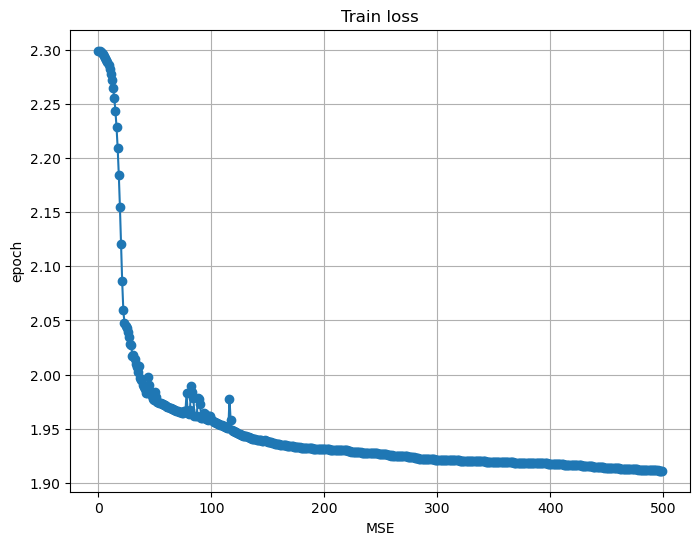

validation error: 1.9677263498306274


In [5]:
model = Autoencoder(input_dim=data_nonfraud_train.shape[1]-1, encoding_dim=8).to(device)

criterion = nn.MSELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.001)

# Train the model
num_epochs = 500
# batch_size = 32
train_err = []
mse_loss = nn.MSELoss(reduction='none')
for epoch in range(num_epochs):
    # for i in range(0, len(data_nonfraud_train), batch_size):
        # inputs = data_nonfraud_train[i:i+batch_size,:-1]
        inputs = data_nonfraud_train[:,:-1]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_err.append(loss.cpu().detach().numpy())
        # loss = mse_loss(outputs, inputs).mean(dim=1)
        # print(inputs.shape)
        # print(outputs.shape)
        # print(loss)
        # break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(data_nonfraud_val[:,:-1])
    # mse_loss = nn.MSELoss(reduction='none')
    # reconstruction_errors = mse_loss(outputs, data_nonfraud_val[:,:-1]).mean(dim=1).numpy()
    reconstruction_errors = criterion(outputs, data_nonfraud_val[:,:-1])

# Plot the list
plt.figure(figsize=(8, 6))
plt.plot(train_err, marker='o')  # Plot with markers for data points
plt.xlabel('MSE')
plt.ylabel('epoch')
plt.title('Train loss')
plt.grid(True)
plt.show()

print(f"validation error: {reconstruction_errors.mean()}")

# threshold = 2.9
# predicted_class = np.where(reconstruction_errors > threshold, 1, 0)
# f1 = f1_score(y_test, predicted_class)

# print("F1 Score:", f1)

we can see the training errors reducing

1.7605536
30.944563


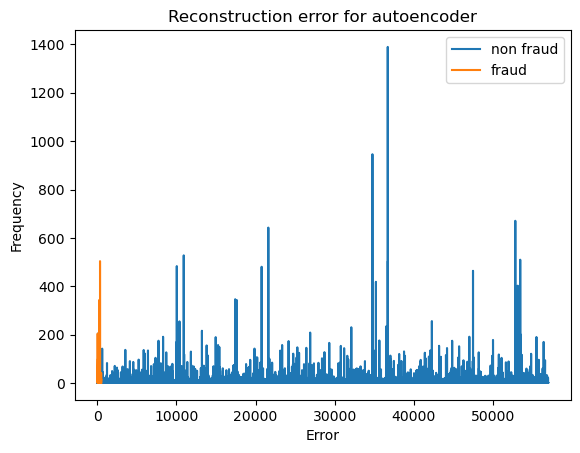

In [6]:
with torch.no_grad():
    outputs_non = model(data_nonfraud_test[:,:-1])
    # print(outputs.size())
    mse_loss = nn.MSELoss(reduction='none')
    reconstruction_errors_non = mse_loss(outputs_non, data_nonfraud_test[:,:-1]).mean(dim=1).to('cpu').numpy()
    # reconstruction_errors_non = criterion(outputs_non, data_nonfraud_test[:,:-1])
    print(reconstruction_errors_non.mean())

    outputs_fraud = model(data_fraud[:,:-1])
    mse_loss = nn.MSELoss(reduction='none')
    reconstruction_errors_fraud = mse_loss(outputs_fraud, data_fraud[:,:-1]).mean(dim=1).to('cpu').numpy()
    # reconstruction_errors_fraud = criterion(outputs_fraud, data_fraud[:,:-1])
    print(reconstruction_errors_fraud.mean())

import pandas as pd
import matplotlib.pyplot as plt

# Plotting both DataFrames on a single plot
plt.plot(reconstruction_errors_non, label='non fraud')
plt.plot(reconstruction_errors_fraud, label='fraud')

# Adding labels and legend
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Reconstruction error for autoencoder')
plt.legend()

plt.show()


Here we can see reconstruction error for fraudulent transactions is higher than non fraudulent

In [7]:
def compute_accuracy(y, yhat):
    correct = (y == yhat).sum().item()
    total = y.size(0)
    accuracy = correct / total
    return accuracy

def compute_false_negatives(y, yhat):
    false_negatives = ((y == 0) & (yhat == 1)).sum().item()
    return false_negatives

with torch.no_grad():
    test_data = torch.cat((data_nonfraud_test,data_fraud))
    outputs = model(test_data[:,:-1])
    mse_loss = nn.MSELoss(reduction='none')
    reconstruction_errors = mse_loss(outputs, test_data[:,:-1]).mean(dim=1)
    y = reconstruction_errors
    threshold = 1.0
    y[y>=threshold] = 1
    y[y<threshold] = 0
    yhat = test_data[:,-1]

accuracy = compute_accuracy(y, yhat)
false_negatives = compute_false_negatives(y, yhat)

print("Accuracy:", accuracy)
print("False Negatives:", false_negatives)
print("F1 score:", multiclass_f1_score(y, yhat, num_classes=2))

Accuracy: 0.7884357648860808
False Negatives: 40
F1 score: tensor(0.7884, device='cuda:0')


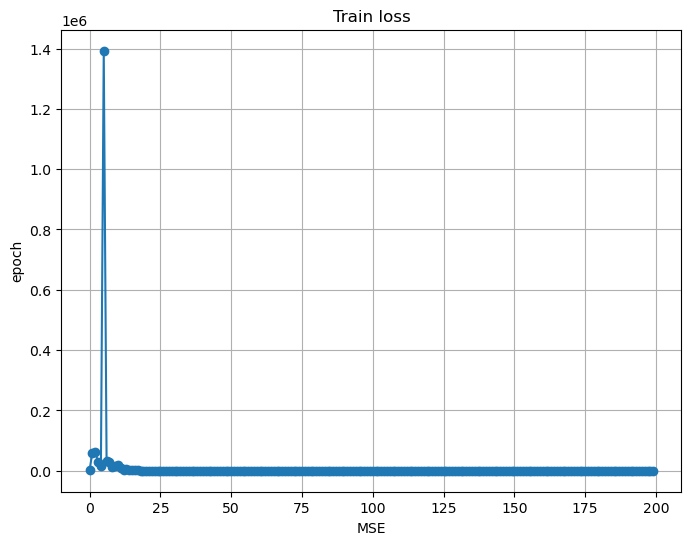

tensor(0.2203, device='cuda:0')


In [8]:
input_dim = data_nonfraud_test[:,:-1].shape[1]
hidden_dim = 350
latent_dim = 5

model = VAE(input_dim, hidden_dim, latent_dim).to(device)

#Rprop converges faster than Adam
optimizer = optim.Rprop(model.parameters(), lr=1e-3)

batch_size = 50000
n_batches = (data_nonfraud_test[:,:-1].size(0) + batch_size - 1) // batch_size  # Calculate how many batches are needed

train_err = []
def train(epoch):
    model.train()
    for e in range(epoch):
        train_loss = 0
        data = data_nonfraud_test[:,:-1].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss = loss.item()
        optimizer.step()
            
        # recon_batch_val, mu, logvar = model(X_val_tensor)
        # loss_val = loss_function(recon_batch_val, X_val_tensor, mu, logvar)
        # print(f'epoch: {e} loss: {train_loss}')
        train_err.append(train_loss)


# for epoch in range(1, num_epochs + 1):
train(200)
model.eval()
with torch.no_grad():
    recon_val, mu, logvar = model(data_nonfraud_val[:,:-1])
    loss_val = mse_loss(recon_val, data_nonfraud_val[:,:-1]).mean(dim=1)#, mu, logvar)
    outputs = model(data_nonfraud_val[:,:-1])

plt.figure(figsize=(8, 6))
plt.plot(train_err, marker='o')  # Plot with markers for data points
plt.xlabel('MSE')
plt.ylabel('epoch')
plt.title('Train loss')
plt.grid(True)
plt.show()

print(reconstruction_errors.mean())

1.7605536
30.944563


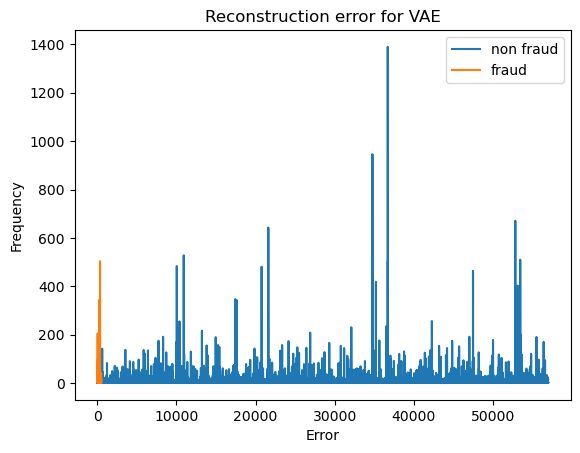

In [9]:
with torch.no_grad():
    recon_non, mu, logvar = model(data_nonfraud_test[:,:-1])
    outputs_non = mse_loss(recon_non, data_nonfraud_test[:,:-1]).mean(dim=1)#, mu, logvar)
    
    print(reconstruction_errors_non.mean())

    recon_fraud, mu, logvar = model(data_fraud[:,:-1])
    outputs_non = mse_loss(recon_fraud, data_fraud[:,:-1]).mean(dim=1)#, mu, logvar)
    
    print(reconstruction_errors_fraud.mean())

import pandas as pd
import matplotlib.pyplot as plt

# Plotting both DataFrames on a single plot
plt.plot(reconstruction_errors_non, label='non fraud')
plt.plot(reconstruction_errors_fraud, label='fraud')

# Adding labels and legend
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Reconstruction error for VAE')
plt.legend()

plt.show()


Here we can see reconstruction error for fraudulent transactions is higher than non fraudulent

In [10]:
recon_test, mu, logvar = model(test_data[:,:-1])
loss_test = mse_loss(recon_test, test_data[:,:-1]).mean(dim=1)#, mu, logvar)

y = loss_test
threshold = 1.0
y[y>=threshold] = 1
y[y<threshold] = 0
yhat = test_data[:,-1]

accuracy = compute_accuracy(y, yhat)
false_negatives = compute_false_negatives(y, yhat)

print("Accuracy:", accuracy)
print("False Negatives:", false_negatives)
print("F1 score:", multiclass_f1_score(y, yhat, num_classes=2))

Accuracy: 0.7449567472542774
False Negatives: 37
F1 score: tensor(0.7450, device='cuda:0')
